# Modélisation de la distribution actuelle et future d'acridien à Madagascar

### Auteurs

## Initialisation

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib.ticker import FuncFormatter
from tabpfn import TabPFNClassifier
from osgeo import gdal
import os
import numpy as np
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from sklearn.inspection import permutation_importance


In [2]:
def transform_map(median_map_folder_path: str, period:str, ssp:str, threshold1: float, threshold2: float, threshold3: float):
    if(period=="1970-2000"):
        map_name = "probability_map_" + period + ".csv"
        name_key="proba"

    else:
        map_name = "median_map_" + period + "_ssp" + ssp +".csv"
        name_key="proba median value"
 
    map_path = os.path.join(median_map_folder_path, map_name)
    if not os.path.exists(map_path):
        raise FileNotFoundError(f"Le fichier '{map_name}' est introuvable dans '{median_map_folder_path}'.")
    
    map = pd.read_csv(map_path)
    columns = map.columns
    col_to_remove = []
    for col in columns:
        if col not in ["proba median value", "geometry", "proba"]:
            col_to_remove.append(col)
    map = map.drop(col_to_remove, axis=1)
 
    map["classified_value"] = np.where(
        map[name_key] >= threshold3, 3,
        np.where(
            map[name_key] >= threshold2, 2,
            np.where(
                map[name_key] >= threshold1, 1,
                0
            )
        )
    )
 
    map[name_key] = map["classified_value"]
    map.drop("classified_value", axis=1, inplace=True)
    if(period=="1970-2000"):
        classified_map_name = "suitability_map" + period + ".csv"
    else:
        classified_map_name = "suitability_median_map" + period + "_ssp" + ssp +".csv"
    map.to_csv(os.path.join(median_map_folder_path, classified_map_name))
    map['geometry'] = map['geometry'].apply(wkt.loads)
    map = gpd.GeoDataFrame(map, geometry="geometry")
    return(map)

def create_tif_maps(map_df, proba_col_name, output_tif):
    bounds = map_df.total_bounds
    transform_obj = from_bounds(
        bounds[0], bounds[1], bounds[2], bounds[3],
        width=1024, height=1024  
    )
    raster = rasterize(
        [(geom, value) for geom, value in zip(map_df.geometry, map_df[proba_col_name])],
        out_shape=(1024, 1024), 
        transform=transform_obj,
        fill=0,
        all_touched=True,
        dtype="float32"
    )
    with rasterio.open(
        output_tif,
        "w",
        driver="GTiff",
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs="EPSG:4326",  
        transform=transform_obj
    ) as dst:
        dst.write(raster, 1)

    print(f"Raster écrit avec succès dans {output_tif}")



def create_suitability_map(suitability_present, out_dir_pred, threshold1, threshold2, threshold3):
    category_colors = {
        0: "blue", 
        1: "lightgreen", 
        2: "yellow",
        3: "red"     
    }
    category_labels = {
        0: fr"Not suitable: P $< {threshold1}$",
        1: fr"Low suitable: ${threshold1} \leq$ P $< {threshold2}$",
        2: fr"Suitable: ${threshold2} \leq$ P $< {threshold3}$",
        3: fr"Very suitable: P $\geq {threshold3}$"
    }

    fig, ax = plt.subplots(figsize=[16, 8])
    for category, color in category_colors.items():
        subset = suitability_present[suitability_present["proba"] == category]
        subset.plot(ax=ax, color=color, label=category_labels[category])
    ax.set_title("Suitability Map for Present Time", fontsize=16)
    ax.set_axis_off()
    legend_elements = [
        Patch(facecolor=color, edgecolor="black", label=label)
        for color, label in zip(category_colors.values(), category_labels.values())
    ]
    fig.legend(
        handles=legend_elements,
        title="Categories",
        loc="center left",
        bbox_to_anchor=(0.6, 0.5),
        fontsize=12
    )
    fig.subplots_adjust(right=0.8)  
    output_path = f"{out_dir_pred}/Maps/present_suitability.png"
    plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.show()



def create_futuresuitability_maps(out_dir_pred, maps_dict, threshold1, threshold2, threshold3):
    descriptions = {
        1: "ssp2-45, 2041-2060",
        2: "ssp5-85, 2041-2060",
        3: "ssp2-45, 2081-2100",
        4: "ssp5-85, 2081-2100"
    }
    category_colors = {
        0: "blue",  
        1: "lightgreen",  
        2: "yellow",  
        3: "red"      
    }
    category_labels = {
        0: fr"Not suitable: P $< {threshold1}$",
        1: fr"Low suitable: ${threshold1} \leq$ P $< {threshold2}$",
        2: fr"Suitable: ${threshold2} \leq$ P $< {threshold3}$",
        3: fr"Very suitable: P $\geq {threshold3}$"
    }
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  
    for idx, ax in enumerate(axes, start=1):
        map_key = f"map{idx}"
        if map_key not in maps_dict:
            ax.text(0.5, 0.5, "No data available", fontsize=14, ha="center", va="center")
            ax.set_title(f"Map {idx}: Data Missing", fontsize=14)
            ax.set_axis_off()
            continue

        description, suitability_table = maps_dict[map_key]
        if not isinstance(suitability_table, gpd.GeoDataFrame):
            raise ValueError(f"Le contenu de {map_key} n'est pas un GeoDataFrame valide.")
        
        for category, color in category_colors.items():
            subset = suitability_table[suitability_table["proba median value"] == category]
            if not subset.empty:
                subset.plot(ax=ax, color=color, label=category_labels[category])

        ax.set_title(f"Suitability Map ({description})", fontsize=14)
        ax.set_axis_off()

    legend_elements = [
        Patch(facecolor=color, edgecolor="black", label=label)
        for category, (color, label) in enumerate(zip(category_colors.values(), category_labels.values()))
    ]
    fig.legend(
        handles=legend_elements,
        title="Categories",
        loc="center right",
        bbox_to_anchor=(1.05, 0.5),  
        fontsize=12
    )

 
    fig.subplots_adjust(right=0.85, wspace=0.2, hspace=0.3)
    output_path = f"{out_dir_pred}/Maps/suitability_future.png"
    plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.show()

## Paramètres

In [3]:
SSP_list = ["245", "585"]
centers_list = ["ACCESS-CM2"] #["ACCESS-CM2", "HadGEM3-GC31-LL", "MIROC6", "IPSL-CM6A-LR", "MPI-ESM1-2-HR", "MRI-ESM2-0", "UKESM1-0-LL"]
periods_list = ["1970-2000", "2041-2060", "2081-2100"]
thresholds=[0.2, 0.46, 0.6]
out_dir="/Users/jean.wallard/Library/CloudStorage/OneDrive-AXACLIMATE/Documents/Ethiopia/LocustInvasion/FilesLocust/ResTabPFN"
inputs_dir="/Users/jean.wallard/Library/CloudStorage/OneDrive-AXACLIMATE/Documents/Ethiopia/LocustInvasion/InputsTabPFN"

## Entraînement du modèle TabPFN 

### Training

<link href="https://fonts.googleapis.com/css2?family=Source+Sans+Pro:wght@400;600&display=swap" rel="stylesheet">
 
<div style="font-family: 'Source Sans Pro', sans-serif; font-size: 16px; line-height: 1.6;">

Le fichier ```final_df.csv``` contient les colonnes avec toutes les données des variables/observations pour l'entraînement (il correspond à la variable ```final_df``` dans le notebook d'origine). Dans la cellule suivante, on s'arrange pour que le jeu d'entraînement soit assez petit (TabPFN tolère jusqu'à 10.000 inputs, mais j'ai l'impression que les time run des fonctions genre ```permutation_importance```, ```predict_proba```.... augmente assez vite avec le nombre). On s'arrange aussi pour qu'il y ait assez de labels ```1``` dans le train/test (ici : moitié-moitié). 

```clf.predict_proba``` prend du temps parfois (plante Kernel), donc si ça plante commencer avec un petit ```train_size```/```test_size```.

In [4]:
final_data = pd.read_csv(f"{inputs_dir}/final_df.csv")
final_data = final_data.drop(columns=["Unnamed: 0.1", "Unnamed: 0", "id"])

feature_cols = [col for col in final_data.columns if col != "observations"]
final_data["presence"] = (final_data["observations"] > 0).astype(np.int32)

class_0 = final_data[final_data["presence"] == 0]
class_1 = final_data[final_data["presence"] == 1]
train_size = 200
test_size = 200

train_size_per_class = train_size // 2
test_size_per_class = test_size // 2

train_size_per_class = min(train_size_per_class, len(class_0), len(class_1))
test_size_per_class = min(test_size_per_class, len(class_0), len(class_1))

train_0 = class_0.sample(n=train_size_per_class, random_state=42)
train_1 = class_1.sample(n=train_size_per_class, random_state=42)
test_0 = class_0.drop(train_0.index).sample(n=test_size_per_class, random_state=42)
test_1 = class_1.drop(train_1.index).sample(n=test_size_per_class, random_state=42)


train_data = pd.concat([train_0, train_1])
test_data = pd.concat([test_0, test_1])

train_xs = train_data[feature_cols].to_numpy()
train_y = train_data["presence"].to_numpy()
target_xs = test_data[feature_cols].to_numpy()
y_test = test_data["presence"].to_numpy()

print("Répartition dans train_y:", np.bincount(train_y))  
print("Répartition dans y_test:", np.bincount(y_test))   


clf = TabPFNClassifier()
clf.fit(train_xs, train_y)


Répartition dans train_y: [100 100]
Répartition dans y_test: [100 100]


TabPFNClassifier()

### Précision

<link href="https://fonts.googleapis.com/css2?family=Source+Sans+Pro:wght@400;600&display=swap" rel="stylesheet">
 
<div style="font-family: 'Source Sans Pro', sans-serif; font-size: 16px; line-height: 1.6;">

Cette cellule prend beaucoup de temps si les inputs de tests sont trop nombreuses, donc commencer petit.

In [5]:
prediction_probabilities = clf.predict_proba(target_xs)
print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

predictions = clf.predict(target_xs)
print("Accuracy:", accuracy_score(y_test, predictions))

ROC AUC: 0.8758
Accuracy: 0.815


### Importance des variables 

<link href="https://fonts.googleapis.com/css2?family=Source+Sans+Pro:wght@400;600&display=swap" rel="stylesheet">
 
<div style="font-family: 'Source Sans Pro', sans-serif; font-size: 16px; line-height: 1.6;">

Cette cellule prend énormément de temps, donc la zapper si besoin.

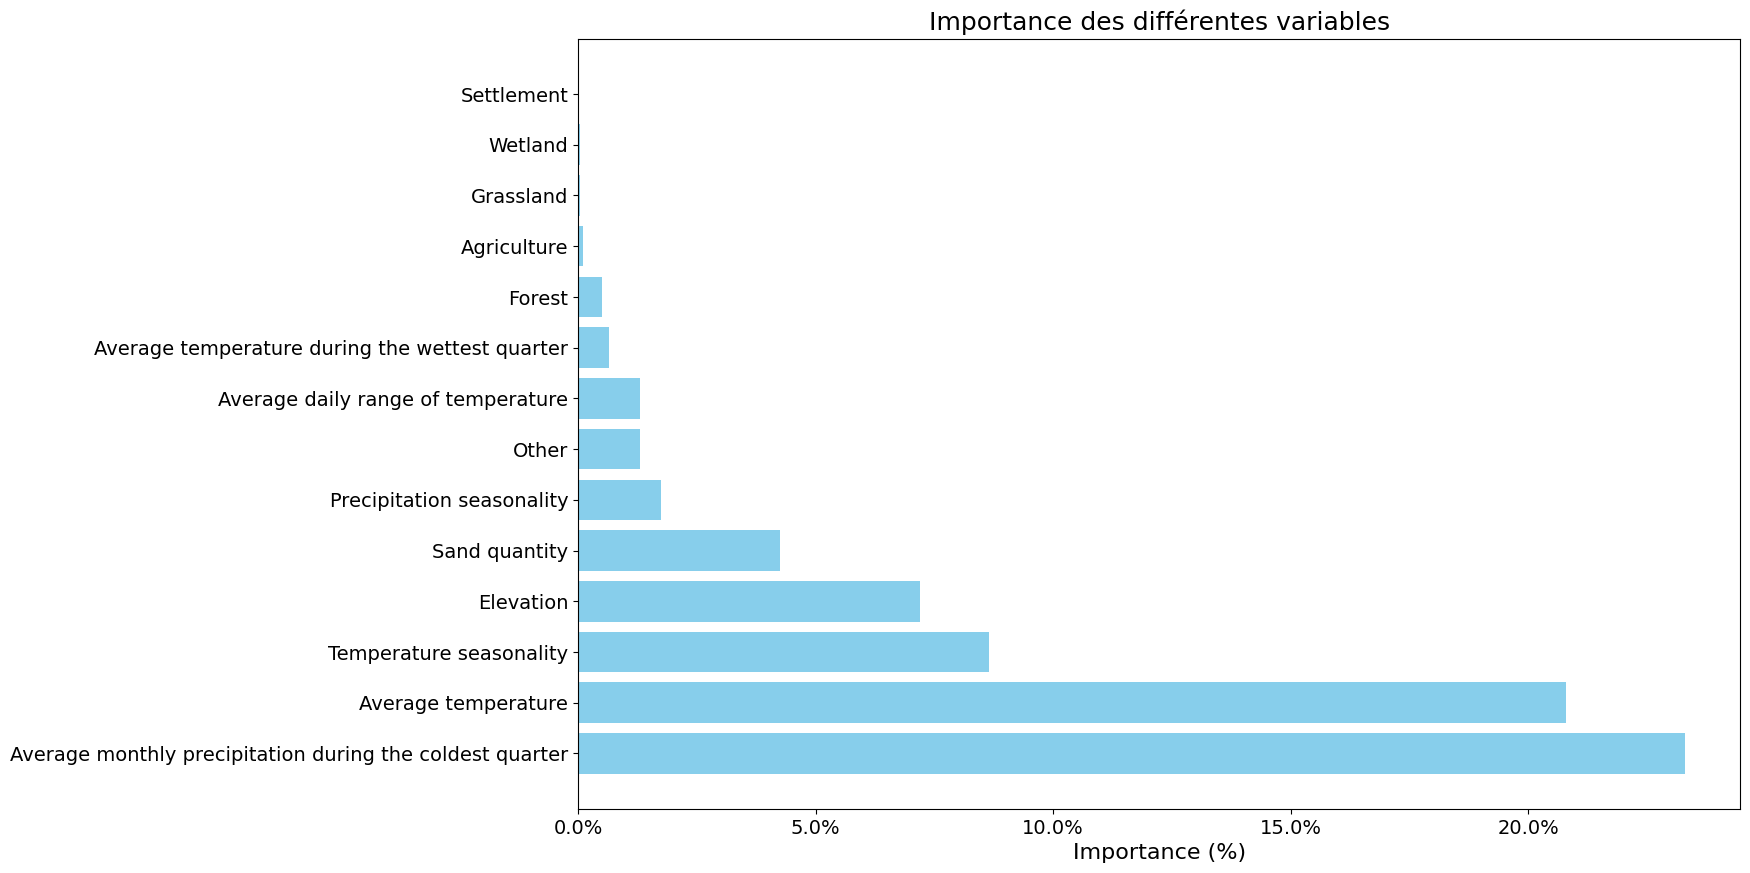

In [6]:
feature_legend = {
    "1": "Average temperature",
    "2": "Average daily range of temperature",
    "4": "Temperature seasonality",
    "8": "Average temperature during the wettest quarter",
    "15": "Precipitation seasonality",
    "19": "Average monthly precipitation during the coldest quarter",
    "sand_0-5cm_resampled": "Sand quantity",
    "wetland": "Wetland",
    "forest": "Forest",
    "grassland": "Grassland",
    "agriculture": "Agriculture",
    "other" : "Other",
    "settlement": "Settlement",
    "elevation": "Elevation"
}


def replace_feature_names(feature_importances, legend_dict):
    feature_importances["Feature"] = feature_importances["Feature"].apply(
        lambda x: legend_dict.get(x, x) 
    )
    return feature_importances
perm_importance = permutation_importance(
        clf, train_xs, train_y, n_repeats=10, random_state=42
    ) #### LOOOOOOOOOONG
importances = perm_importance.importances_mean
feature_importances = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
feature_importances = replace_feature_names(feature_importances, feature_legend)


fig, ax = plt.subplots(figsize=[15, 10])
ax.barh(feature_importances["Feature"], feature_importances["Importance"], color="skyblue")
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
ax.set_xlabel('Importance (%)', fontsize=16)
ax.set_title('Importance des différentes variables', fontsize=18)
plt.show()


## Downscaling 

<link href="https://fonts.googleapis.com/css2?family=Source+Sans+Pro:wght@400;600&display=swap" rel="stylesheet">
 
<div style="font-family: 'Source Sans Pro', sans-serif; font-size: 16px; line-height: 1.6;">

Comme le modèle prend du temps à run, on s'arrange pour grossir la résolution spatiale (pas besoin de faire à 100m). ```n_rescale``` permet de choisir par combien tu veux regrouper les pixels (ex : ```n_rescale=3```= regrouper les pixels par 6 => 600m x 600m). Après la deuxième cellule, la nouvelle grille de terre ferme est dans ```reference_baseline_Madagascar_downscaled.shp``` (ou ```land_ref```). Pas hésiter à grossir ```n_rescale```.

Pour faire la jointure spatiale entre les data et les identifiants des pixels (```probas_shp = pd.merge(land_ref, preds_df, on="id", how="inner", validate="1:1"``` dans la partie d'après), on s'arrange pour que les gros pixels prennent pour id celui du petit pixel central.

In [7]:
n_rescale=6

cmd=f"""gdal_translate -a_srs EPSG:4326 \
-tr {0.025*n_rescale/3} {0.025*n_rescale/3} \
{inputs_dir}/reference_baseline_Madagascar.tiff \
{inputs_dir}/reference_baseline_Madagascar_downscaled.vrt"""

os.system(cmd)
conn_params = {
    "dbname": "my_database",
    "user": "jean.wallard",
    "password": "123456",
    "host": "localhost",
    "port": "5432"
}

cmd=f"""gdal_polygonize \
{inputs_dir}/reference_baseline_Madagascar_downscaled.vrt \
-f PostgreSQL PG:"dbname={conn_params["dbname"]} user={conn_params["user"]} password={conn_params["password"]} host={conn_params["host"]} port={conn_params["port"]}" \
reference_baseline_madagascar_downscaled"""

os.system(cmd)

Input file size is 878, 1639
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [ ]:
engine = create_engine(f"postgresql://{conn_params['user']}:{conn_params['password']}@{conn_params['host']}:{conn_params['port']}/{conn_params['dbname']}")
conn = psycopg2.connect(**conn_params)
cursor = conn.cursor()
query = """ALTER TABLE reference_baseline_madagascar_downscaled 
DROP COLUMN IF EXISTS id;"""

cursor.execute(query)
conn.commit()

query = """
ALTER TABLE reference_baseline_madagascar_downscaled 
DROP COLUMN IF EXISTS id;

ALTER TABLE reference_baseline_madagascar_downscaled 
ADD COLUMN id INT;

UPDATE reference_baseline_madagascar_downscaled AS b
SET id = l.id
FROM land_ref AS l
WHERE ST_Intersects(l.geometry, ST_Centroid(b.wkb_geometry));
"""
cursor.execute(query)
conn.commit()



gdf = gpd.read_postgis(
    "SELECT id, wkb_geometry FROM reference_baseline_madagascar_downscaled",
    conn,
    geom_col="wkb_geometry"
)

gdf.to_file(f"{inputs_dir}/reference_baseline_Madagascar_downscaled.shp")


## Prédiction sur baseline

<link href="https://fonts.googleapis.com/css2?family=Source+Sans+Pro:wght@400;600&display=swap" rel="stylesheet">
 
<div style="font-family: 'Source Sans Pro', sans-serif; font-size: 16px; line-height: 1.6;">
 

```clf.predict_proba``` prend du temps parfois (plante Kernel), donc si ça plante commencer avec un petit ```train_size```.

In [ ]:


model_land_ref_path = f"{inputs_dir}/reference_baseline_Madagascar_downscaled.shp"
path = out_dir
os.makedirs(f"{path}/Results")
period = "1970-2000"

land_ref = gpd.read_file(model_land_ref_path)
final_df = pd.read_csv(f"{inputs_dir}/prediction_database_baseline.csv")

print("Predicting on AOI")

final_df_filtered = final_df[final_df['id'].isin(land_ref['id'])]
final_df=final_df_filtered

feature_data = final_df[feature_cols].to_numpy()
y_pred = clf.predict_proba(feature_data)[:, 1] #### LOOOOOOOOOONG

print("Prediction finished")
preds_df = pd.DataFrame({"id": final_df["id"].tolist(), "proba": y_pred})
print("Datframe preds_df finished")

land_ref = land_ref.drop_duplicates(subset=['id'])
probas_shp = pd.merge(land_ref, preds_df, on="id", how="inner", validate="1:1")
print("Probas_shp merged")
probas_shp.to_file(f"{path}/proba_shp_baseline.shp", driver="ESRI Shapefile")
print("Probas_shp to file")

print("Generating suitability map")
_, ax = plt.subplots(figsize=(10, 10))
probas_shp.plot(ax=ax, column="proba", legend=True, cmap="jet")
ax.set(title=f"Suitability map for species : criquets")
ax.figure.savefig(f"{path}/suitability_map.jpeg", format="jpeg")
plt.close(ax.figure)

print(f"Map generated for species criquets")

land_ref = gpd.read_file(model_land_ref_path)
preds_df = pd.merge(preds_df, land_ref, on="id")
preds_df.to_csv(f"{path}/Results/probability_map_{period}.csv", index=False)


Predicting on AOI
Prediction finished
Datframe preds_df finished
Probas_shp merged
Probas_shp to file
Generating suitability map
Map generated for species criquets


## Prédictions dans le futur 

<link href="https://fonts.googleapis.com/css2?family=Source+Sans+Pro:wght@400;600&display=swap" rel="stylesheet">
 
<div style="font-family: 'Source Sans Pro', sans-serif; font-size: 16px; line-height: 1.6;">
 

```SSP_list``` ne contient ici que le modèle ```ACCESS-CM2``` (juste 4 cartes à générer pour prendre moins de temps).

In [ ]:

for period in ["2041-2060", "2081-2100"]:
    path = os.path.join(out_dir, "Results")
    os.makedirs(path, exist_ok=True)
    for ssp in SSP_list:
        
        for center in centers_list:
            final_df = pd.read_csv(f"{inputs_dir}/prediction_database_{period}_{ssp}_{center}.csv")
            final_df_filtered = final_df[final_df['id'].isin(land_ref['id'])]
            final_df=final_df_filtered
            print("Predicting on AOI")
            feature_data = final_df[feature_cols].to_numpy() 
            y_pred = clf.predict_proba(feature_data) #### LOOOOOOOOOONG
            land_ref = land_ref.drop_duplicates(subset=['id'])
            preds_df = pd.DataFrame({"id": final_df["id"].tolist(), "proba": y_pred[:, 1]})
            probas_shp = pd.merge(land_ref, preds_df, on="id", how="inner", validate="1:1")
            probas_shp.to_file(path + f"/proba_shp_{period}_{ssp}_{center}.shp", driver="ESRI Shapefile")
            print("Generating suitability map")
            _, ax = plt.subplots(figsize=(10, 10))
            probas_shp.plot(ax=ax, column="proba", legend=True, cmap="jet")
            ax.set(title=f"Suitability map for species : criquets")
            ax.figure.savefig(f"{path}/suitability_map.jpeg", format="jpeg")
            plt.close(ax.figure)
            print(f"Map generated for species criquets")
            preds_df.to_csv(f"{path}/probability_map_{period}_{center}_ssp{ssp}.csv")   

Predicting on AOI
Generating suitability map
Map generated for species criquets
Predicting on AOI
Generating suitability map
Map generated for species criquets
Predicting on AOI
Generating suitability map
Map generated for species criquets
Predicting on AOI
Generating suitability map
Map generated for species criquets


In [ ]:
col = []
for center in centers_list:
    col.append(f"proba {center}")

path = os.path.join(out_dir, "Results")
for period in ["2041-2060", "2081-2100"]:
    for ssp in SSP_list:
        median_map = gpd.read_file(model_land_ref_path)
        for center in centers_list:
            center_map = pd.read_csv(f"{path}/probability_map_{period}_{center}_ssp{ssp}.csv")
            center_map.drop("Unnamed: 0", axis=1, inplace=True)
            center_map.rename(columns={"proba":f"proba {center}"}, inplace=True)
            median_map = pd.merge(median_map,center_map,on="id")
        median_map["proba median value"] = median_map[col].mean(axis=1)
        median_map.to_csv(f"{path}/median_map_{period}_ssp{ssp}.csv")

## Génération des cartes

In [ ]:
map1 = pd.read_csv(f"{out_dir}/Results/median_map_2041-2060_ssp245.csv")
map1['geometry'] = map1['geometry'].apply(wkt.loads)
map1 = gpd.GeoDataFrame(map1, geometry="geometry")
map2 = pd.read_csv(f"{out_dir}/Results/median_map_2041-2060_ssp585.csv")
map2['geometry'] = map2['geometry'].apply(wkt.loads)
map2 = gpd.GeoDataFrame(map2, geometry="geometry")
map3 = pd.read_csv(f"{out_dir}/Results/median_map_2081-2100_ssp245.csv")
map3['geometry'] = map3['geometry'].apply(wkt.loads)
map3 = gpd.GeoDataFrame(map3, geometry="geometry")
map4 = pd.read_csv(f"{out_dir}/Results/median_map_2081-2100_ssp585.csv")
map4['geometry'] = map4['geometry'].apply(wkt.loads)
map4 = gpd.GeoDataFrame(map4, geometry="geometry")
map_present = pd.read_csv(f"{out_dir}/Results/probability_map_1970-2000.csv")
map_present['geometry'] = map_present['geometry'].apply(wkt.loads)
map_present = gpd.GeoDataFrame(map_present, geometry="geometry")


path_res=f"{out_dir}/Results"
threshold1, threshold2, threshold3= thresholds
suitability_present = transform_map(path_res, "1970-2000", "", threshold1, threshold2, threshold3)
suitability_1 = transform_map(path_res, "2041-2060", "245", threshold1, threshold2, threshold3)
suitability_2 = transform_map(path_res, "2041-2060", "585", threshold1, threshold2, threshold3)
suitability_3 = transform_map(path_res, "2081-2100", "245", threshold1, threshold2, threshold3)
suitability_4 = transform_map(path_res, "2081-2100", "585", threshold1, threshold2, threshold3)


Raster écrit avec succès dans /Users/jean.wallard/Library/CloudStorage/OneDrive-AXACLIMATE/Documents/Ethiopia/LocustInvasion/FilesLocust/ResTabPFN/Results/present_suitability.tif


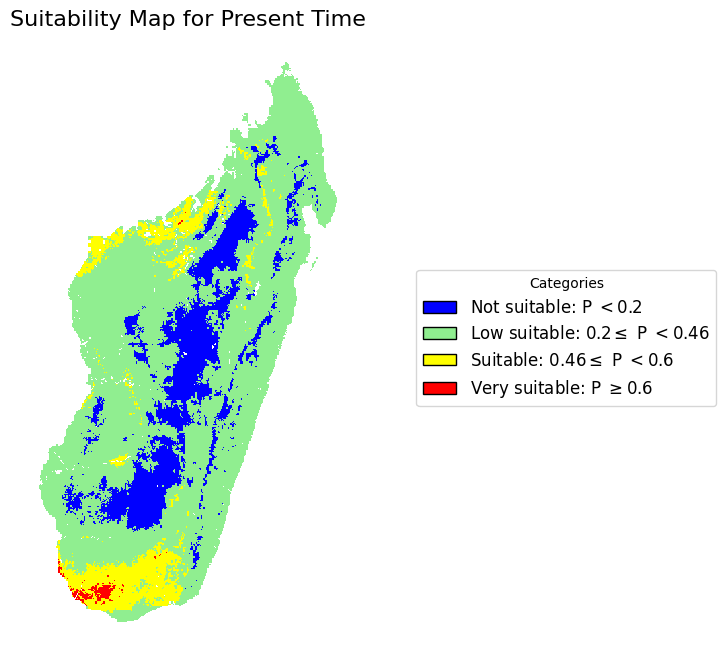

In [ ]:
os.makedirs(f"{path_res}/Maps", exist_ok=True)
create_tif_maps(suitability_present, "proba", f"{path_res}/present_suitability.tif")
create_suitability_map(suitability_present, path_res, threshold1, threshold2, threshold3)

Raster écrit avec succès dans /Users/jean.wallard/Library/CloudStorage/OneDrive-AXACLIMATE/Documents/Ethiopia/LocustInvasion/FilesLocust/ResTabPFN/Results/ssp245_2041_2060_suitability.tif
Raster écrit avec succès dans /Users/jean.wallard/Library/CloudStorage/OneDrive-AXACLIMATE/Documents/Ethiopia/LocustInvasion/FilesLocust/ResTabPFN/Results/ssp585_2041_2060_suitability.tif
Raster écrit avec succès dans /Users/jean.wallard/Library/CloudStorage/OneDrive-AXACLIMATE/Documents/Ethiopia/LocustInvasion/FilesLocust/ResTabPFN/Results/ssp245_2081_2100_suitability.tif
Raster écrit avec succès dans /Users/jean.wallard/Library/CloudStorage/OneDrive-AXACLIMATE/Documents/Ethiopia/LocustInvasion/FilesLocust/ResTabPFN/Results/ssp585_2081_2100_suitability.tif


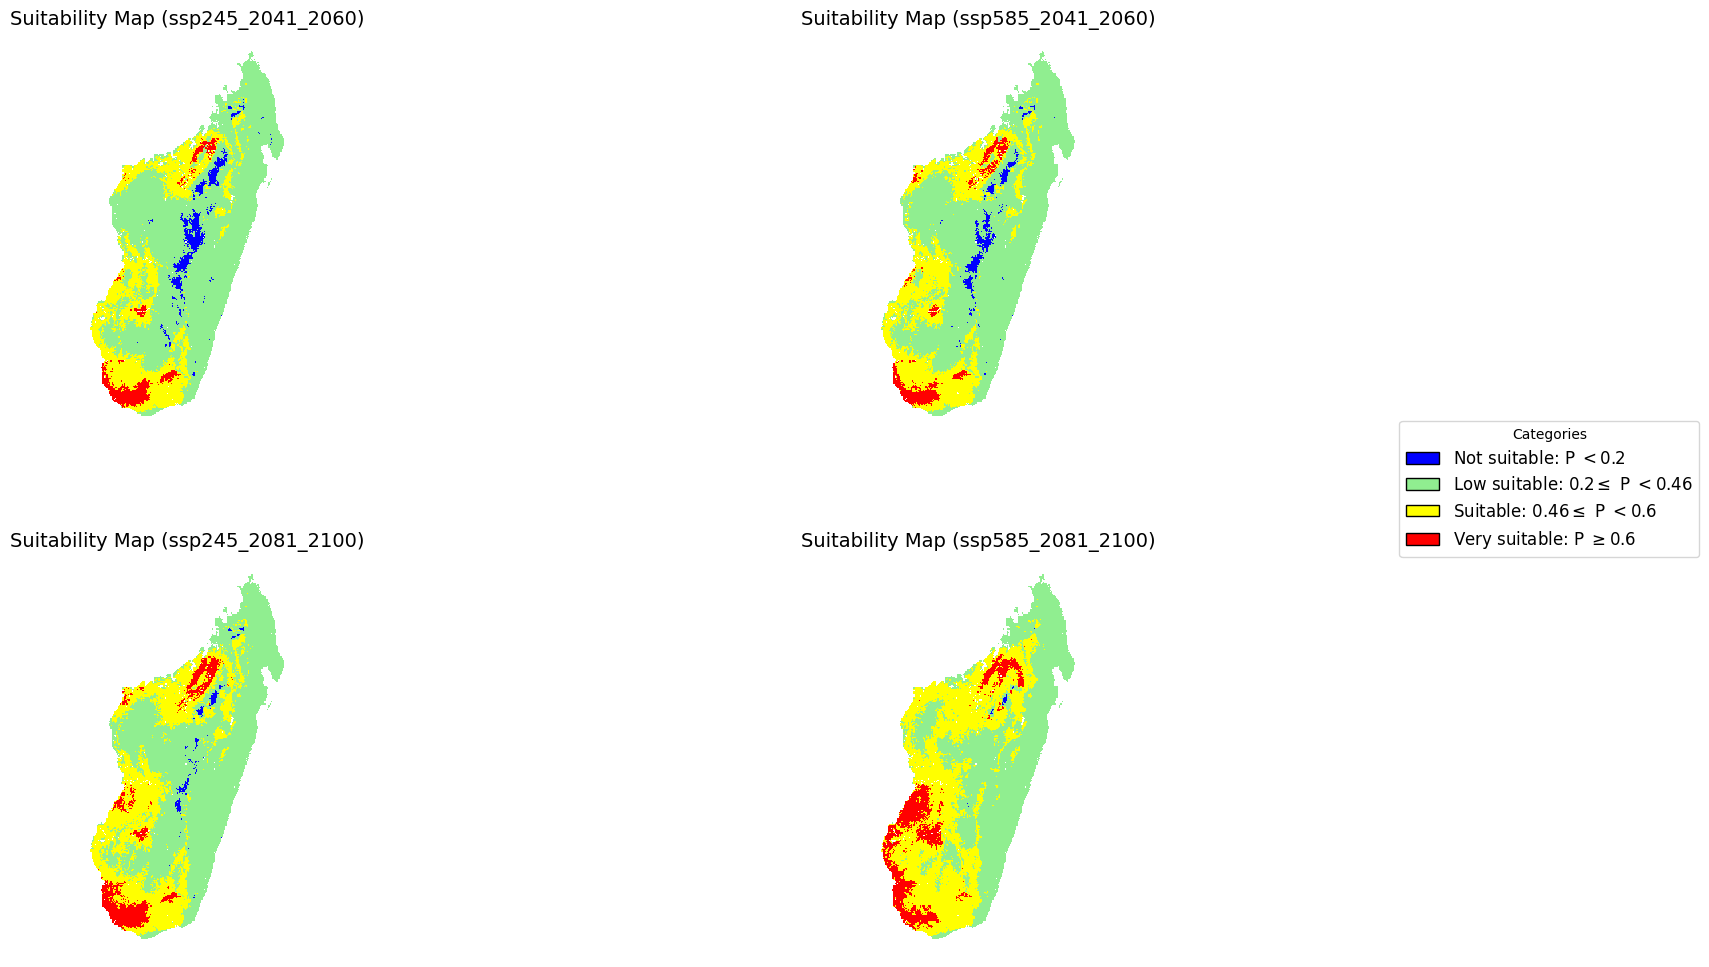

In [ ]:
maps_dict = {
    'map1': ('ssp245_2041_2060', suitability_1),
    'map2': ('ssp585_2041_2060', suitability_2),
    'map3': ('ssp245_2081_2100', suitability_3),
    'map4': ('ssp585_2081_2100', suitability_4)
}

for key, (description, current_map) in maps_dict.items():
    create_tif_maps(current_map, "proba median value", f"{path_res}/{description}_suitability.tif")
    
create_futuresuitability_maps(path_res, maps_dict, threshold1, threshold2, threshold3)